In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data
from mldec.models import baselines
from mldec.utils import evaluation
from mldec.codes import repetition_code

### hyperparameter tuning notes

 - Feb 26 runs: 50k training data, p=0.15, knob turning = [0.1, 0.15, 0.2, 0.25]
   - Basically the run failed: No discernable difference between any of the p performances. Hypothesis is that this is due to a very large training sample: basically all of our runs get to "see" the important examples for 50000 data points. So lets choke that and see what happens. Trying again for 1k 

- Feb 27 runs: 1k training data, p=0.15, knob turning = [0.1, 0.15, 0.2, 0.25]
  - still no signal. Lets try to really boost what we're looking for. I will make true p smaller, bias smaller, and a knob p much larger so if there is any training difference we should se it. $p=0.1$, $\alpha=0.7$ and knob goes either $p\in [0.1, 0.3]$. $N=2000$ and doubled the patience to 4000 epochs.

- Feb 28 runs: Found a bug. 2k training data, p=0.10, alpha=0.7
- April 23 runs: additional FFNN experiments


In [ ]:
def compare_slice_by_column(df, column, slice_by):
    best = df[df[slice_by] == 1]
    other = df[df[slice_by] != 1]
    best = best[column]
    other = other[column]
    if column == 'lr':
        best = np.log10(best)
        other = np.log10(other)
    cts, bins, _ = plt.hist(best, bins=20, alpha=1, color='r', label='perfect')
    plt.hist(other, bins=bins, alpha=0.5, color='b', label='rest')
    plt.legend()
    plt.title(column)
    plt.show()

check_hypers = False
if check_hypers:
    # target = "mldec_results.xlsx"
    target = "ffnn-v0.2/ffnn_toy_problem_only_good_examples_results.csv"
    df_ffnn = pd.read_csv(target)
    ffnn_columns = ['lr', 'dropout', 'hidden_dim', 'n_layers', 'batch_size']
    for column in ffnn_columns:
        compare_slice_by_column(df_ffnn, column, 'val_acc')

    df = pd.read_excel("mixed-v0/mldec_results.xlsx", sheet_name=None)
    df_cnn = df['cnn_toy_problem_only_good_examp']
    df_xformer = df['xformer_only_good_examples']
    cnn_columns = ['lr', 'dropout', 'kernel_size', 'conv_channels', 'n_layers', 'batch_size']
    xformer_columns = ['lr', 'dropout', 'd_model', 'num_encoder_layers', 'num_decoder_layers', 'nhead', 'dim_feedforward', 'batch_size']
    for column in cnn_columns:
        compare_slice_by_column(df_cnn, column, 'val_acc')
    for column in xformer_columns:
        compare_slice_by_column(df_xformer, column, 'val_acc')

In [2]:
# model = "transformer"
target_xformer = "xformer-v0/transformer_toy_problem_results_N2000.csv"
target_cnn = "cnn-v0/cnn_toy_problem_results_N2000_v4.csv"
target_ffnn = "ffnn-v1.0/ffnn_toy_problem_results_N2000.csv"
df_x = pd.read_csv(target_xformer)
df_cnn = pd.read_csv(target_cnn)
df_ffnn = pd.read_csv(target_ffnn)


In [3]:
# compute optimal performance on this dataset
p = 0.1
alpha = 0.7
n = 8
dataset_config = {"p": p, "alpha": alpha, "pcm": toy_problem_data.repetition_pcm(n)}
X, Y, good_weights = toy_problem_data.uniform_over_good_examples(n, dataset_config)
X, Y, true_weights = toy_problem_data.create_dataset_training(n, dataset_config)

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, true_weights) 
print(f"Lookup table accuracy: {mld_acc}")

Lookup table accuracy: 0.9988024234771729


C:\Users\peter\Desktop\projects\mldec\src\mldec\models\baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(out)


In [ ]:
# solve for the violation of wellorderedness 
def froot(x):
    return (x / (1-x)) ** 4 - ( (alpha * x) / (1 - alpha * x)) ** 2

# find the root
from scipy.optimize import root_scalar
root = root_scalar(froot, x0=0.5) #overshoot since 0 is also a root

In [5]:
n_samp = 22
alpha_samp = 0.33
p1_samp = 0.15
p2_samp = p1_samp * alpha
good_wt_hist, unimp_wt_hist, imp_wt_hist, bad_wt_hist, all_wt_hist = repetition_code.histogram_good_important_bad(n_samp, p1_samp, alpha_samp)
# turning the knob
pp_samp = 0.25
good_wt_hist_k, unimp_wt_hist_k, imp_wt_hist_k, bad_wt_hist_k, all_wt_hist_k = repetition_code.histogram_good_important_bad(n_samp, pp_samp, alpha_samp)
weights = np.array(list(imp_wt_hist.keys()))

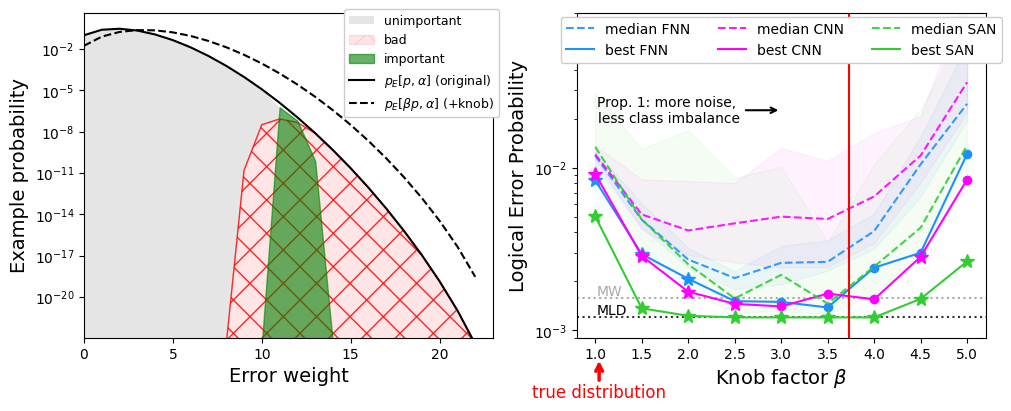

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1A: DISTRIBUTION OF EXAMPLES FOR GOOD/BAD/IMPORTANT
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def dezero(x, y, zero=0):
    y = np.array(list(y))
    y[y == 0] = zero
    x[y == 0] = zero
    return x, y
    # return x[y >= zero], y[y >= zero]

x_all, y_all = dezero(weights, all_wt_hist.values())
zero = min(y_all)
x_good, y_good = dezero(weights, good_wt_hist.values(), zero=zero)
x_unimp, y_unimp = dezero(weights, unimp_wt_hist.values(), zero=zero)
x_imp, y_imp = dezero(weights, imp_wt_hist.values(), zero=zero)
x_bad, y_bad = dezero(weights, bad_wt_hist.values(), zero=zero)

w = 1/3
ax0 = axes[0]
zero = min(y_all)
ax0.fill_between(x_unimp[:n_samp//2 + 1], y_bad[:n_samp//2 + 1], y_unimp[:n_samp//2 + 1], 
                 label='unimportant', facecolor="gray", alpha=0.2)
ax0.fill_between(x_bad, np.ones_like(y_bad) * zero, y_bad, 
                 label='bad', facecolor="r", hatch="x", edgecolor="r", alpha=0.1)
ax0.fill_between(x_bad, np.ones_like(y_bad) * zero, y_bad, 
                 facecolor='none', hatch="x", edgecolor="r", alpha=0.8) #matplotlib rendering bug https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf
ax0.fill_between(x_imp, np.ones_like(y_imp) * zero, y_imp, label='important', facecolor="g", edgecolor='g', alpha=0.6, )
ymin = zero * 3


# overlay of turning the knob
x_all_pp, y_all_pp = dezero(weights, all_wt_hist_k.values())
ax0.plot(x_all, y_all, label=r'$p_E[p, \alpha]$ (original)', color='k', alpha=1)
ax0.plot(x_all_pp, y_all_pp, label=r"$p_E[\beta p, \alpha]$ (+knob)", color='k', alpha=1, linestyle='--')
ax0.semilogy()
labelsz = 14
ax0.set_xlabel(r"Error weight", fontsize=labelsz)
ax0.set_ylabel('Example probability', fontsize=labelsz)
ax0.legend(prop={'size': 9}, framealpha=1, loc='upper right', bbox_to_anchor=(1.03, 1.03))

ax0.set_ylim(ymin, ax0.get_ylim()[1] + 0.1)
ax0.set_xlim(0, n_samp + 1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIG 1B: PERFORMANCE WITH TURNING THE KNOB
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#get the min weight performance
colors = ['dodgerblue', 'fuchsia', 'limegreen']
ax = axes[1]
vs_minweight = df_x[df_x['p'] == p]['vs_minweight'].values
minweight = df_x[df_x['p'] == p]['val_acc'] - vs_minweight
min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...
ax.axhline(min_minweight_err, ls=':', c='darkgray', alpha=1)#, label='minimum weight')
ax.axhline(1 - mld_acc , ls=':', c='k', alpha=0.8)#, label='MLD')
ax.text(1.02, min_minweight_err + 0.00005, f"MW", c='darkgray', size=10, ha='left')
ax.text(1.02, 1 - mld_acc + 0.00005 , f"MLD", size=10, ha='left')

for jj, (df, model) in enumerate(zip([df_ffnn, df_cnn, df_x], ['FNN', 'CNN', 'SAN'])):
 
    # compute performance/stats on each of the models
    pvals = sorted(df['p'].unique())
    xvals = np.array(pvals) / 0.1
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, p in enumerate(pvals):
        y = df[df['p'] == p]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        y_ub = y_err.quantile(.75)
        y_lb = y_err.quantile(0.25)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # # Also get the min weight performance
        # vs_minweight = df[df['p'] == p]['vs_minweight'].values
        # minweight = y - vs_minweight
        # min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['p'] == p]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)
    color = colors[jj]
    ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.05)
    ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.9, label=f'median {model}')
    ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=f'best {model}')
    # wherever the result is better than lookup, plot a star
    for i, p in enumerate(pvals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 10
        else:
            marker = 'o'
            markersize = 6
        ax.plot(p / 0.1, yerrs_mins[i], marker=marker, c=color, markersize=markersize)



ax.set_xlabel(r"Knob factor $\beta$", size=14)
# draw an arrow pointing to x=0.10, y=0.01
ax.semilogy()
ax.axvline(root.root / 0.1, ls='-', c='red', alpha=1)
ax.legend(framealpha=1, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.01))
ax.set_ylim([9e-4, 9e-2])
ax.set_ylabel("Logical Error Probability", size=14)
    
# Add an arrow annotation below the x-axis pointing at x=1
axes[1].annotate("true distribution", 
            xy=(0.055, -0.05 ),  # Use axis coordinates (x, y)
            xytext=(0.055, -0.14),  # Position text below the axis using axis coordinates
            size=12,  
            ha='center',
            va='top',
            color='red',
            # fontweight='bold',  # Make text bold to increase visibility
            # bbox=dict(facecolor='white', alpha=0.7, edgecolor='red', pad=3),  # Add background to text
            arrowprops=dict(
                arrowstyle='->',
                color='red',
                linewidth=2.5,  # Increased linewidth for visibility
                shrinkA=0,
                shrinkB=5  # Added some shrinkage to avoid overlapping with text
            ),
            xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
            textcoords='axes fraction')  # Use axis fraction coordinates for the text
axes[1].annotate("Prop. 1: more noise, \nless class imbalance", 
            xy=(0.5, .7 ),  # Use axis coordinates (x, y)
            xytext=(0.4, .7 ),  # Position text further left to avoid overlap
            size=10,  
            ha='right',
            va='center',
            color='k',
            # bbox=dict(facecolor='white', alpha=0.7, edgecolor='k', pad=3),  # Add background to text
            arrowprops=dict(
                arrowstyle='->',
                color='k',
                linewidth=1.5,  # Increased linewidth for visibility
                # shrinkA=200,  # Ensure arrow starts outside the text box
                # shrinkB=200  # Added some shrinkage to avoid overlapping with text
            ),
            xycoords='axes fraction',  # Use data coordinates for the arrow endpoint
            textcoords='axes fraction')  # Use axis fraction coordinates for the text

axes[1].annotate("", xy=(0.10, yerrs_mins[0] * .9), xytext=(0.10, yerrs_mins[0] *.35 ), arrowprops=dict(arrowstyle='->', color='r', linewidth=2))


fig.savefig(f"../../figures/fig1_full.pdf", bbox_inches='tight')